In [1]:
# import
import pandas as pd
import numpy as np
import glob
import warnings
warnings.filterwarnings('ignore')
#import matplotlib.pyplot as plt
import itertools
import numpy as np
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# Machine Learning libraries.
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,f_classif

/Users/raviagrawal/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/raviagrawal/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
k=10

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    


def Classifier_performance(clf, target_names, y, filledData, X_train, X_test, y_train, y_test, title="confusion matrix"):
    # Fitting the training data
    clf.fit(X_train, y_train)
    
    # Predicting the data
    y_pred = clf.predict(X_test)
    Y_train_pred = clf.predict(X_train)
    
    # Printing the accuracies and confusion matrix
    print("Training Accuracy Score: ", accuracy_score(Y_train_pred , y_train))
    print("validation Accuracy Score:", accuracy_score(y_pred, y_test))
    print("Classification Report: ")
    print(classification_report(y_test, y_pred, target_names=target_names))
    cm = confusion_matrix(y_test, y_pred)
    # Plot normalized confusion matrix
    #plt.figure()
    plot_confusion_matrix(cm, classes=target_names, normalize=False,
                          title=title)

    plt.show()
    plt.close()
    
    # Showing the lower dimension data projection using PCA
    pca = PCA(n_components=2)
    
    # Fitting and transformed the data
    filledData_lower = pca.fit_transform(filledData)
    y = pd.Series(y)
    filledData_lower = pd.DataFrame(filledData_lower)
    filledData_lower['labels'] = y.values
    
    # Creating the figure
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15) # X Axis
    ax.set_ylabel('Principal Component 2', fontsize = 15) # Y Axis
    ax.set_title('2 component PCA', fontsize = 20) # Title
    crash = filledData_lower[filledData_lower["labels"] == 1]
    no_crash = filledData_lower[filledData_lower["labels"] == 0]
    ax.plot(crash[0], crash[1], "*", label=target_names[0])
    ax.plot(no_crash[0], no_crash[1], "o", label=target_names[1])
    plt.legend()
    plt.show()
    plt.close()

In [4]:
leftTurn = pd.read_excel("leftturn_new.xlsx")
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent","preIncidentManeuver","crashStatus", "crash", "maneuverJudgment", "incomplete_video", "vehicle_movement"], axis = 1)

In [5]:
# Filling empty value in the questionary variable with zero
temp = data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']]
temp.fillna(0, inplace = True)
temp = temp.replace("(null)", 0)
data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']] = temp

filledData = data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']]    

In [6]:
# Getting the crash Status
y = leftTurn["crashStatus"]

# Crash and near crash as one field 
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and no Crash: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

# Traing test split of the data 
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.8, random_state=42)

Number of crashs events:  145.0
Class Balance with Crash and no Crash:  0.506993006993007


# Predicting Crash risk of all the drivers using Support Vector Machine considering crash and near crash as one entry.

In [7]:
# Loading neccesary library for the support vector machine
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

/Users/raviagrawal/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Training Accuracy Score:  0.5570175438596491
validation Accuracy Score: 0.603448275862069
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.63      0.61      0.62        31
      Crash       0.57      0.59      0.58        27

avg / total       0.60      0.60      0.60        58

Confusion matrix, without normalization
[[19 12]
 [11 16]]


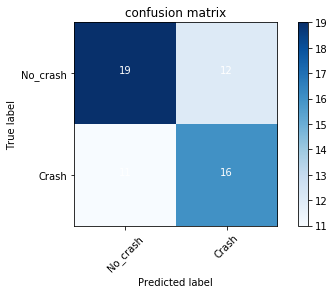

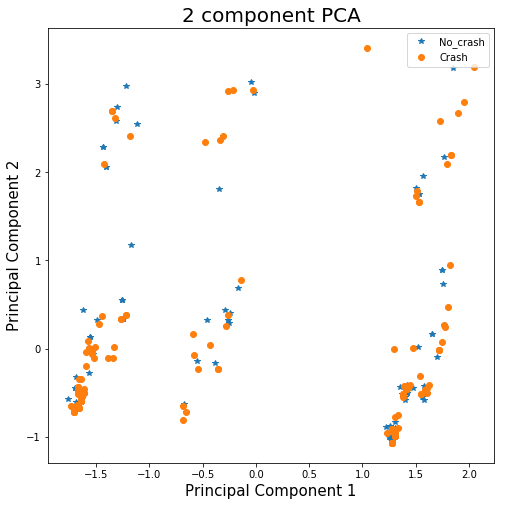

In [8]:
clf = LogisticRegression( penalty='l1')
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Support Vector Machine Learning Model to predict crash and no crash risk

Training Accuracy Score:  0.8157894736842105
validation Accuracy Score: 0.5344827586206896
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.56      0.58      0.57        31
      Crash       0.50      0.48      0.49        27

avg / total       0.53      0.53      0.53        58

Confusion matrix, without normalization
[[18 13]
 [14 13]]


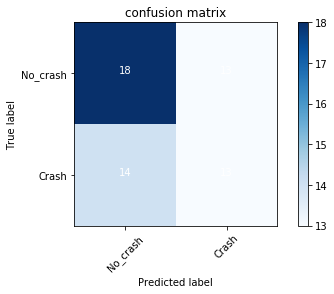

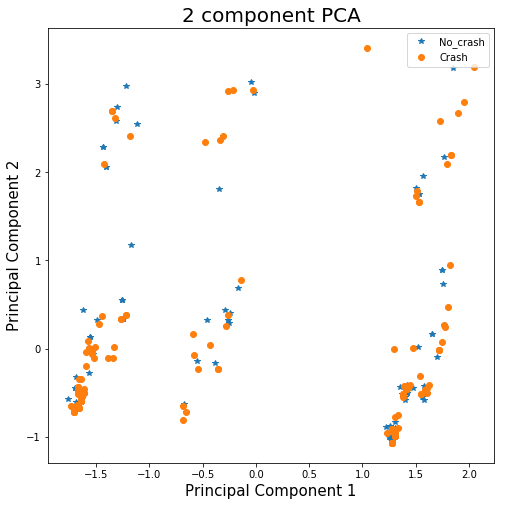

In [9]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [10]:
clf.best_estimator_

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=9, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#  Random Forest Based Machine Learning Models


Training Accuracy Score:  0.8245614035087719
validation Accuracy Score: 0.5689655172413793
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.60      0.58      0.59        31
      Crash       0.54      0.56      0.55        27

avg / total       0.57      0.57      0.57        58

Confusion matrix, without normalization
[[18 13]
 [12 15]]


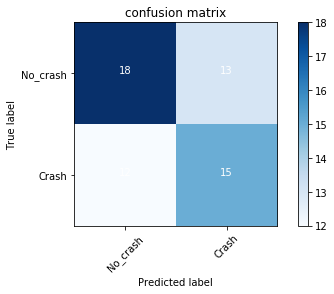

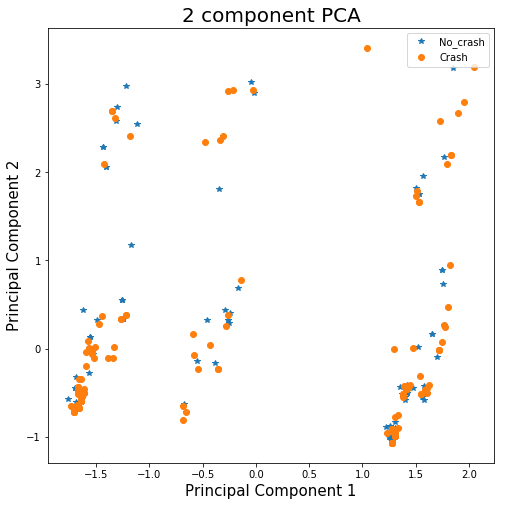

In [11]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [12]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     24.48
Date:                Wed, 24 Oct 2018   Prob (F-statistic):           7.14e-33
Time:                        11:36:58   Log-Likelihood:                -217.87
No. Observations:                 286   AIC:                             455.7
Df Residuals:                     276   BIC:                             492.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
slpSched           0.1465      0.078      1.

# Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

In [13]:
leftTurn = pd.read_excel("leftturn_new.xlsx")

# removing the near crash files.
leftTurn = leftTurn[leftTurn["crashStatus"] != 'Near-Crash'] 

data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)


# Filling empty value in the questionary variable with zero
temp = data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']]
temp.fillna(0, inplace = True)
temp = temp.replace("(null)", 0)
data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']] = temp

filledData = data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']]    

# Filling Qualtrics Varible with 1


y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)

print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of crashs events:  37.0
Class Balance with Crash and Baseline Condition:  0.20786516853932585


Training Accuracy Score:  0.7903225806451613
validation Accuracy Score: 0.7962962962962963
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.80      1.00      0.89        43
      Crash       0.00      0.00      0.00        11

avg / total       0.63      0.80      0.71        54

Confusion matrix, without normalization
[[43  0]
 [11  0]]


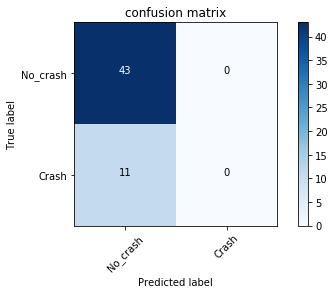

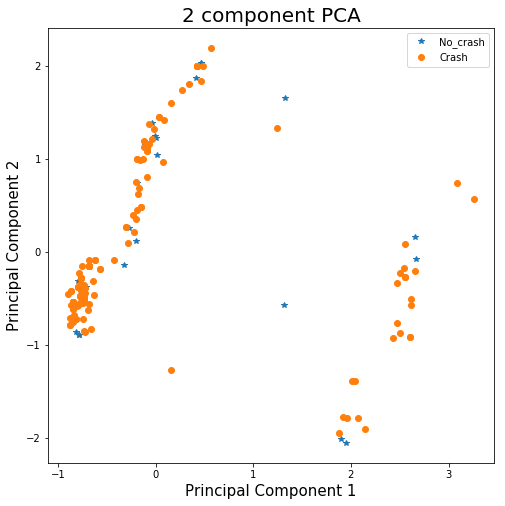

In [14]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model :
    Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

Training Accuracy Score:  0.8629032258064516
validation Accuracy Score: 0.7777777777777778
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.80      0.95      0.87        43
      Crash       0.33      0.09      0.14        11

avg / total       0.71      0.78      0.72        54

Confusion matrix, without normalization
[[41  2]
 [10  1]]


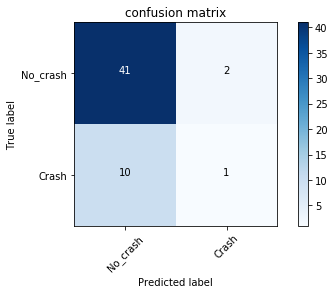

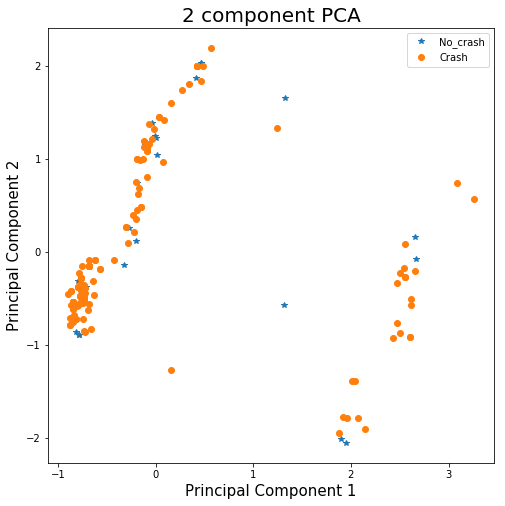

In [15]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
    Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

Training Accuracy Score:  0.8467741935483871
validation Accuracy Score: 0.7777777777777778
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.79      0.98      0.88        43
      Crash       0.00      0.00      0.00        11

avg / total       0.63      0.78      0.70        54

Confusion matrix, without normalization
[[42  1]
 [11  0]]


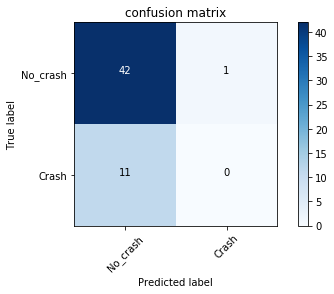

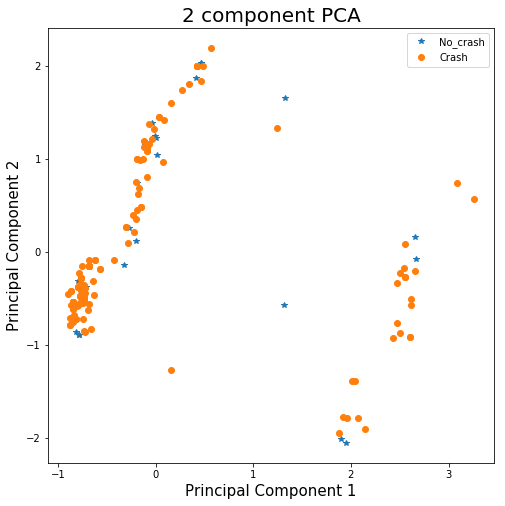

In [16]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [18]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     4.876
Date:                Wed, 24 Oct 2018   Prob (F-statistic):           3.57e-06
Time:                        11:38:01   Log-Likelihood:                -90.085
No. Observations:                 178   AIC:                             200.2
Df Residuals:                     168   BIC:                             232.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
slpSched              0.0405      0.08

# Predicting if the driver is young or old from their driving data all 275 data used


In [19]:
leftTurn = pd.read_excel("leftturn_new.xlsx")
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type', "crashStatus", "age"], axis = 1)

# Filling empty value in the questionary variable with zero
temp = data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']]
temp.fillna(0, inplace = True)
temp = temp.replace("(null)", 0)
data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']] = temp

filledData = data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']]    

y = leftTurn["age"]
y[y >= 65] = True
y[y != True] = False
y  = np.asarray(y,dtype=np.float64)
print("Number of old drivers: ", sum(y))
print("Class Balance with old drivers and young driver: ", sum(y)/len(y))

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of old drivers:  177.0
Class Balance with old drivers and young driver:  0.6188811188811189


Training Accuracy Score:  0.71
validation Accuracy Score: 0.6744186046511628
Classification Report: 
             precision    recall  f1-score   support

      Young       0.61      0.34      0.44        32
        Old       0.69      0.87      0.77        54

avg / total       0.66      0.67      0.65        86

Confusion matrix, without normalization
[[11 21]
 [ 7 47]]


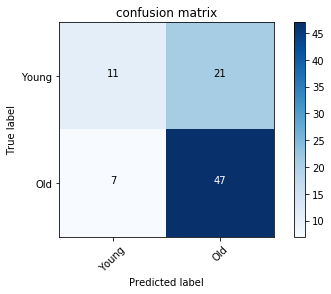

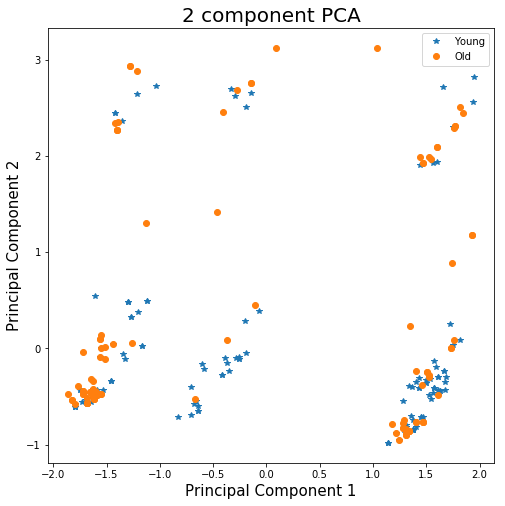

In [20]:
clf = LogisticRegression(max_iter=1000, penalty='l1')
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model :
Predicting if the driver is young or old from their driving data all 275 data used¶

Training Accuracy Score:  0.71
validation Accuracy Score: 0.7093023255813954
Classification Report: 
             precision    recall  f1-score   support

      Young       0.67      0.44      0.53        32
        Old       0.72      0.87      0.79        54

avg / total       0.70      0.71      0.69        86

Confusion matrix, without normalization
[[14 18]
 [ 7 47]]


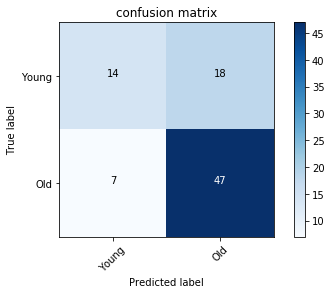

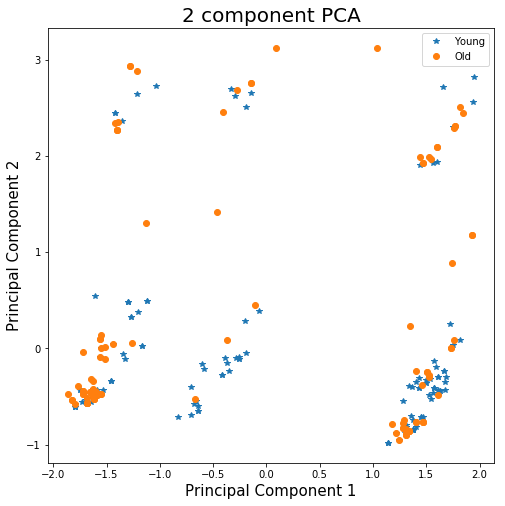

In [21]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

Training Accuracy Score:  0.925
validation Accuracy Score: 0.6976744186046512
Classification Report: 
             precision    recall  f1-score   support

      Young       0.64      0.44      0.52        32
        Old       0.72      0.85      0.78        54

avg / total       0.69      0.70      0.68        86

Confusion matrix, without normalization
[[14 18]
 [ 8 46]]


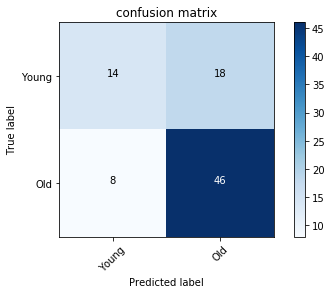

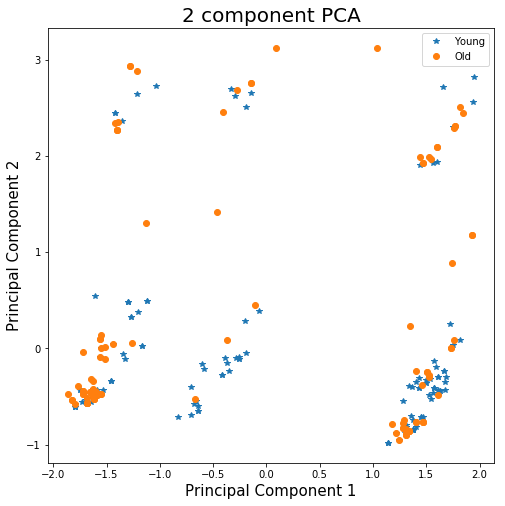

In [22]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [23]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     41.87
Date:                Wed, 24 Oct 2018   Prob (F-statistic):           1.05e-49
Time:                        11:38:41   Log-Likelihood:                -205.21
No. Observations:                 286   AIC:                             430.4
Df Residuals:                     276   BIC:                             467.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
slpSched              0.3746      0.06

# Model to predict old driver at risk of crash or not

In [24]:
leftTurn = pd.read_excel("leftturn_new.xlsx")

old_crash = leftTurn[(leftTurn["age"]>=65) & ((leftTurn["crashStatus"]=="Crash"))]
old_baseline = leftTurn[(leftTurn["age"]>=65) & (leftTurn["crashStatus"]=="Balanced-Sample Baseline")][:30]
leftTurn = pd.concat([old_crash, old_baseline])
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

# Filling empty value in the questionary variable with zero
temp = data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']]
temp.fillna(0, inplace = True)
temp = temp.replace("(null)", 0)
data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']] = temp

filledData = data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']]    



y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)


print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of crashs events:  25.0
Class Balance with Crash and Baseline Condition:  0.45454545454545453


Training Accuracy Score:  0.6842105263157895
validation Accuracy Score: 0.4117647058823529
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.46      0.67      0.55         9
   Old drivers at risk       0.25      0.12      0.17         8

           avg / total       0.36      0.41      0.37        17

Confusion matrix, without normalization
[[6 3]
 [7 1]]


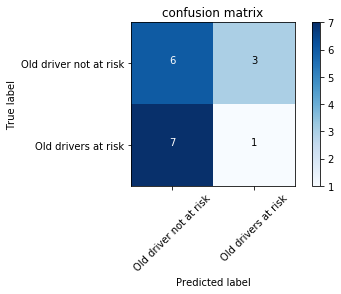

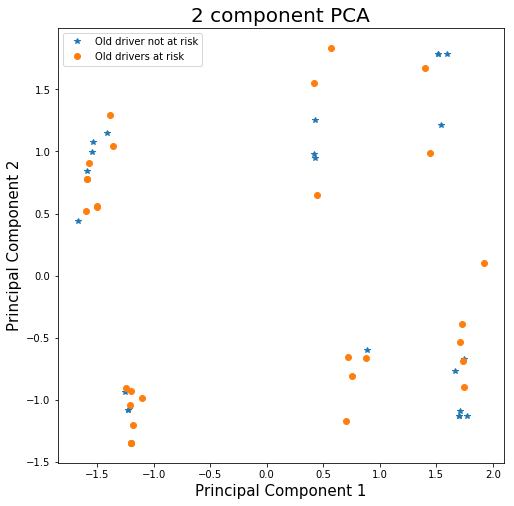

In [25]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model to predict old driver at risk of crash or not:

Training Accuracy Score:  0.6052631578947368
validation Accuracy Score: 0.5882352941176471
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.56      1.00      0.72         9
   Old drivers at risk       1.00      0.12      0.22         8

           avg / total       0.77      0.59      0.49        17

Confusion matrix, without normalization
[[9 0]
 [7 1]]


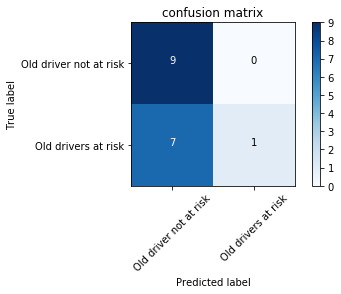

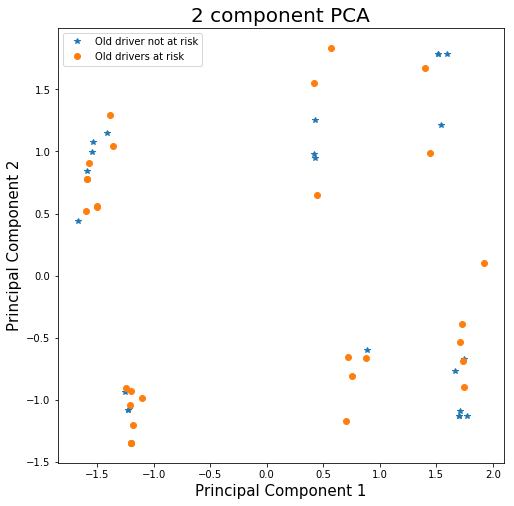

In [26]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
    predict old driver at risk of crash or not:


Training Accuracy Score:  0.8947368421052632
validation Accuracy Score: 0.7058823529411765
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.70      0.78      0.74         9
   Old drivers at risk       0.71      0.62      0.67         8

           avg / total       0.71      0.71      0.70        17

Confusion matrix, without normalization
[[7 2]
 [3 5]]


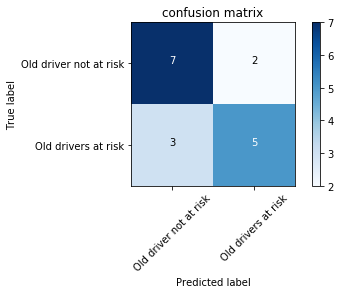

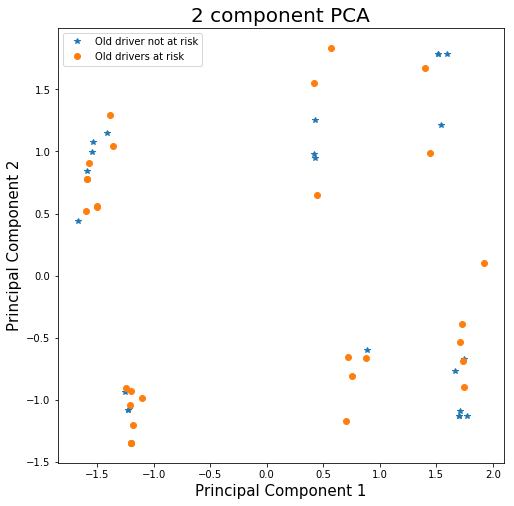

In [27]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [28]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     3.506
Date:                Wed, 24 Oct 2018   Prob (F-statistic):            0.00176
Time:                        11:39:29   Log-Likelihood:                -40.515
No. Observations:                  55   AIC:                             101.0
Df Residuals:                      45   BIC:                             121.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
slpSched              0.1596      0.24

# drivers 65 or less at the crash risk or not

In [29]:
leftTurn = pd.read_excel("leftturn_new.xlsx")

young_crash = leftTurn[(leftTurn["age"]<=65) & ((leftTurn["crashStatus"]=="Crash"))]
young_baseline = leftTurn[(leftTurn["age"]<=65) & (leftTurn["crashStatus"]=="Balanced-Sample Baseline")][:20]
leftTurn = pd.concat([young_crash, young_baseline])
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

# Filling empty value in the questionary variable with zero
temp = data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']]
temp.fillna(0, inplace = True)
temp = temp.replace("(null)", 0)
data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']] = temp

filledData = data[['slpSched', 'slperTyp', 'nodOffWhlDrvng', 'qltyofSlp',
       'driverRestriction', 'numViol', 'numCrash', 'passTrnVeh', 'rage',
       'wrngWay', 'missLead', 'wrngLnInt']]    

# Filling Qualtrics Varible with 1
y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)


print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))

selector = SelectKBest(f_classif, k=k).fit(filledData, y)
columns = filledData.columns[selector.get_support()]
filledData = filledData[np.array(columns)]

X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7, random_state=42)

Number of crashs events:  10.0
Class Balance with Crash and Baseline Condition:  0.3333333333333333


Training Accuracy Score:  0.6666666666666666
validation Accuracy Score: 0.7777777777777778
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.78      1.00      0.88         7
   Old drivers at risk       0.00      0.00      0.00         2

           avg / total       0.60      0.78      0.68         9

Confusion matrix, without normalization
[[7 0]
 [2 0]]


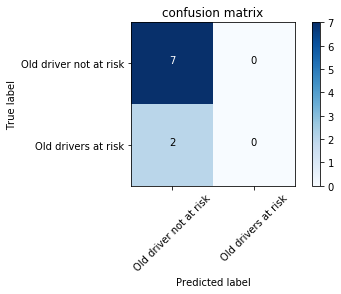

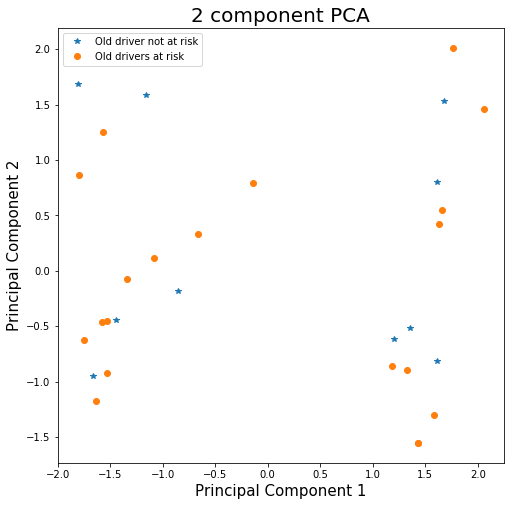

In [30]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# SVM Based model to predict drivers 65 or less at the crash risk or not¶


Training Accuracy Score:  0.6190476190476191
validation Accuracy Score: 0.7777777777777778
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.78      1.00      0.88         7
   Old drivers at risk       0.00      0.00      0.00         2

           avg / total       0.60      0.78      0.68         9

Confusion matrix, without normalization
[[7 0]
 [2 0]]


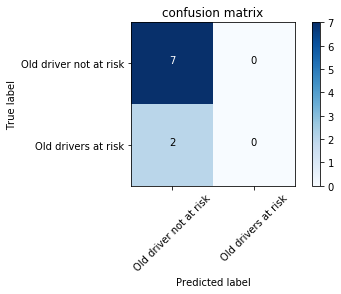

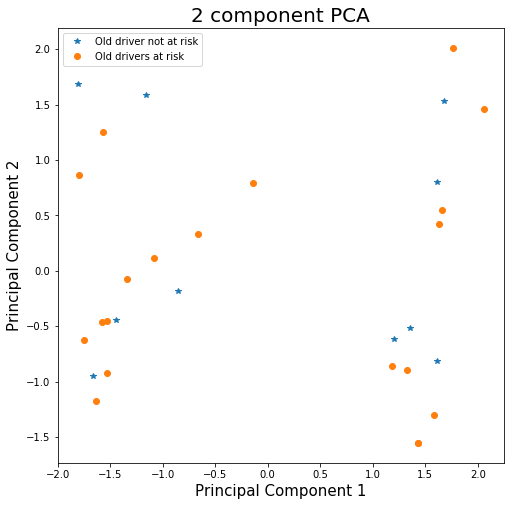

In [ ]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 5, 10, 0.5, 0.25, 0.125, 0.065], "degree":[3, 5, 7, 9, 15]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=3)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

# Random Forest Based Machine Learning Models¶:
drivers 65 or less at the crash risk or not¶¶

In [ ]:
parameters = {"n_estimators":[1, 5, 10, 25, 50, 100, 250], "criterion":["gini", "entropy"], "max_depth":[5, 10, 26, 50, 100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=7)
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [ ]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())